# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
>
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [ ]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change).
    They are parallel and located at opposite ends of the frame.
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.

In [ ]:
l = 50 * 10**(-2) # in meters
r = 12.5 * 10**(-2) #in meters
pass

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

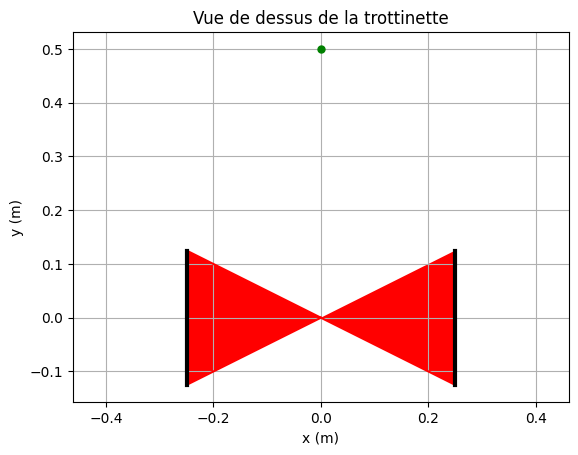

In [ ]:
import matplotlib.pyplot as plt

def draw_scooter(x, y, theta):
    # Définition des dimensions
    l = 50/100    # Longueur du cadre du siège en centimètres
    r = 12.5/100  # Rayon de la roue en centimètres

    # Calcul des coordonnées des points du cadre
    cadre_points = np.array([[x, y],
                             [x - l/2, y + r],
                             [x - l/2, y - r],
                             [x + l/2, y + r],
                             [x + l/2, y - r]])

    # Transformation des coordonnées en fonction de l'angle theta
    rotation_matrix = np.array([[np.sin(theta), np.cos(theta)],
                                [np.cos(theta), -np.sin(theta)]])
    rotated_cadre_points = np.dot(cadre_points - [x, y], rotation_matrix) + [x, y]

    # Dessin du cadre
    plt.plot(rotated_cadre_points[:,0], rotated_cadre_points[:,1], 'r-')

    # Dessin et remplissage des triangles représentant les patins
    plt.fill([rotated_cadre_points[0,0], rotated_cadre_points[1,0], rotated_cadre_points[2,0], rotated_cadre_points[0,0]],
             [rotated_cadre_points[0,1], rotated_cadre_points[1,1], rotated_cadre_points[2,1], rotated_cadre_points[0,1]], 'r')
    plt.fill([rotated_cadre_points[0,0], rotated_cadre_points[3,0], rotated_cadre_points[4,0], rotated_cadre_points[0,0]],
             [rotated_cadre_points[0,1], rotated_cadre_points[3,1], rotated_cadre_points[4,1], rotated_cadre_points[0,1]], 'r')

    # Dessin des roues aux extrémités des patins avec une épaisseur de ligne plus importante
    plt.plot([rotated_cadre_points[1,0], rotated_cadre_points[2,0]], [rotated_cadre_points[1,1], rotated_cadre_points[2,1]], 'k-', linewidth=3)
    plt.plot([rotated_cadre_points[3,0], rotated_cadre_points[4,0]], [rotated_cadre_points[3,1], rotated_cadre_points[4,1]], 'k-', linewidth=3)

    # Calcul des coordonnées du marqueur vert indiquant la direction avant
    forward_marker_x = x + 50/100 * np.cos(theta)
    forward_marker_y = y + 50/100 * np.sin(theta)

    # Dessin du marqueur vert
    plt.plot(forward_marker_x, forward_marker_y, 'go', markersize=5)

    # Configuration des axes
    plt.axis('equal')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('Vue de dessus de la trottinette')

    # Affichage
    plt.grid(True)


# Exemple d'utilisation
draw_scooter(0, 0, pi/2)


🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [ ]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

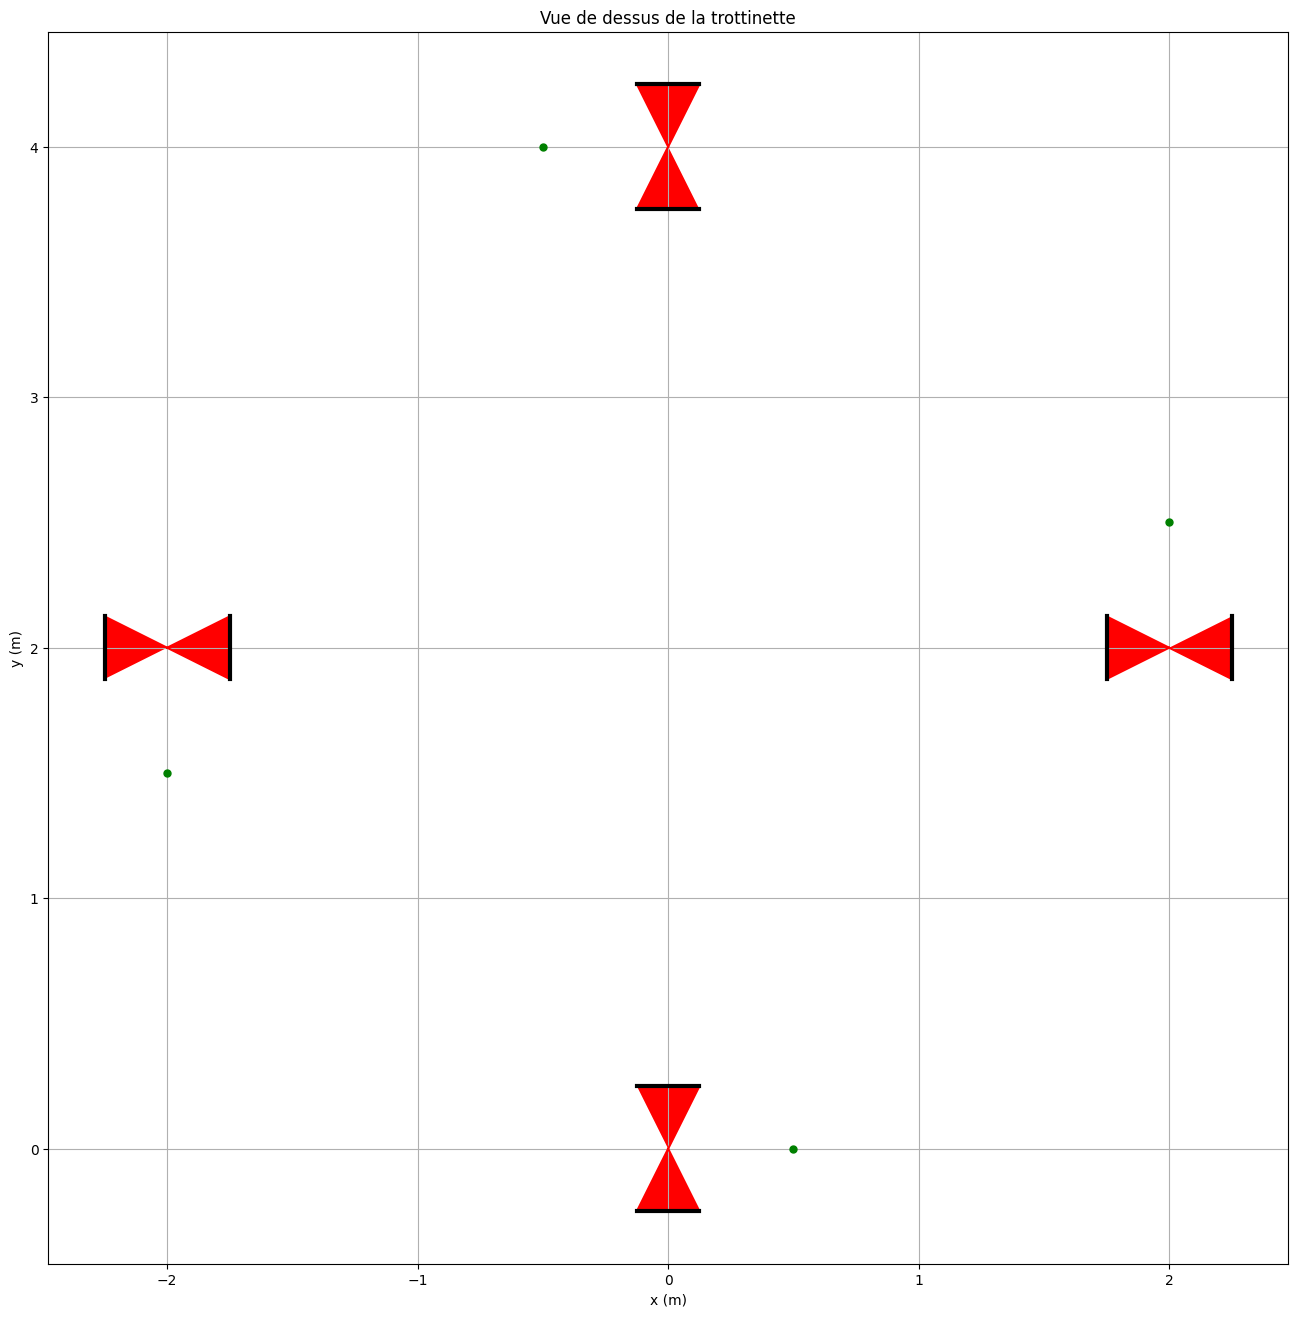

In [ ]:
# Call draw_arena function to draw the arena
draw_arena(-5, 5, -5, 5)

# Define positions (x, y, θ)
positions = [(0, 0, 0), (2, 2, np.pi/2), (0, 4, np.pi), (-2, 2, 3*np.pi/2)]

# Call draw_scooter function for each position
for pos in positions:
    draw_scooter(*pos)

# Show the plot
plt.show()


### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping.

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

$$
\text{Vitesse linéaire moyenne du robot: } v = \frac{{v_r + v_l}}{2}
$$

$$
\text{Vitesse angulaire du robot: } \omega = \frac{{v_r - v_l}}{L}
$$

$$
\text{Dérivée de } x: \dot{x} = v \cdot \cos(\theta)
$$

$$
\text{Dérivée de } y: \dot{y} = v \cdot \sin(\theta)
$$

$$
\text{Dérivée de } \theta: \dot{\theta} = \frac{r}{L} \cdot (v_r - v_l)
$$


**TODO**

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

The state variable is $X = (x, y, \theta)$. \\
Our system is governed by the following IVP:
\begin{align*}
    \dot{X} &= f(X) \\
    f(X) &= \begin{pmatrix}
        \frac{r}{2} (w_l + w_r) \cos(\theta) \\
        \frac{r}{2} (w_l + w_r) \sin(\theta) \\
        \frac{r}{l} (w_r - w_l)
    \end{pmatrix}
\end{align*}

Since the inputs $w_l$ and $w_r$ are continuously differentiable, then $f$ is also continuously differentiable. Thus, the IVP has a unique and continuous solution, indicating that the system is well posed.

**TODO**

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

If \( \omega_l \) and \( \omega_r \) are constants, then the function \( f(X) \) becomes constant as well. This means that the system's dynamics are time-independent. Consequently, solutions to the IVP exist for all time, and since the inputs are constant, the solution trajectory remains within the state space indefinitely. Therefore, the maximal solution associated with any initial state is indeed global.


**TODO**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [ ]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [ ]:
import numpy as np

def fun(t, xytheta):
    x, y, theta = xytheta

    # Compute omega using the given function omega
    omega_l, omega_r = omega(t, xytheta)

    # Calculate linear and angular velocities of the wheels
    v_l = r * omega_l
    v_r = r * omega_r

    # Calculate average linear velocity of the robot
    v = (v_r + v_l) / 2.0

    # Calculate angular velocity of the robot
    omega = (v_r - v_l) / L

    # Calculate rates of change of x, y, and theta
    x_dot = v * np.cos(theta)
    y_dot = v * np.sin(theta)
    theta_dot = omega

    return np.array([x_dot, y_dot, theta_dot])

pass

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

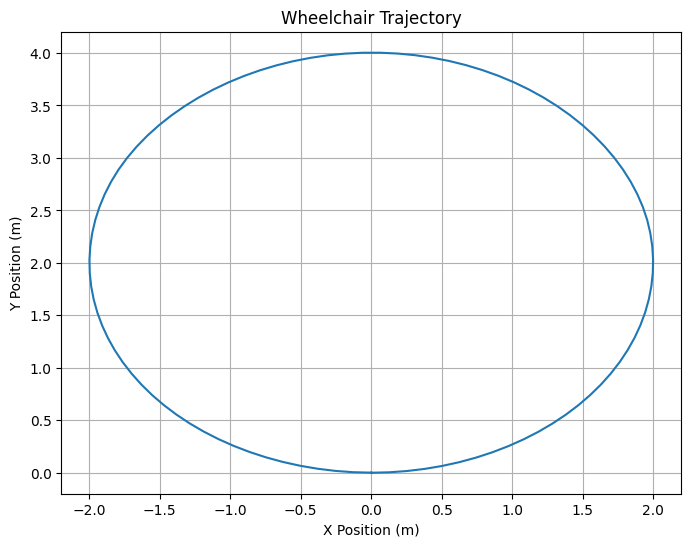

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
r = 12.5/100 # Radius of the wheel (meters)
l = 50/100  # Distance between the wheels (meters)
initial_state = [0.0, 0.0, 0.0]  # Initial state [x0, y0, theta0]

# Function to compute omega given t and (x, y, theta)
def omega(t, xytheta):
    omega_l = (1 - l/4) * np.pi / r
    omega_r = (1 + l/4) * np.pi / r
    return np.array([omega_l, omega_r])

# Function to compute the derivative of the state
def fun(t, xytheta, omega_func):
    x, y, theta = xytheta

    # Compute omega using the given function omega
    omega_l, omega_r = omega_func(t, xytheta)

    # Calculate linear and angular velocities of the wheels
    v_l = r * omega_l
    v_r = r * omega_r

    # Calculate average linear velocity of the robot
    v = (v_r + v_l) / 2.0

    # Calculate angular velocity of the robot
    omega = (v_r - v_l) / l

    # Calculate rates of change of x, y, and theta
    x_dot = v * np.cos(theta)
    y_dot = v * np.sin(theta)
    theta_dot = omega

    return np.array([x_dot, y_dot, theta_dot])

# Define the time span
t_span = (0, 4)  # From t=0 to t=4 seconds

# Solve the differential equations numerically
solution = solve_ivp(lambda t, y: fun(t, y, omega), t_span, initial_state, method='RK45', dense_output=True)

# Compute dense outputs
t_dense = np.linspace(0, 4, 100)
states_dense = solution.sol(t_dense)

# Plot the trajectory
plt.figure(figsize=(8, 6))
plt.plot(states_dense[0], states_dense[1])
plt.title("Wheelchair Trajectory")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid(True)
plt.show()


🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

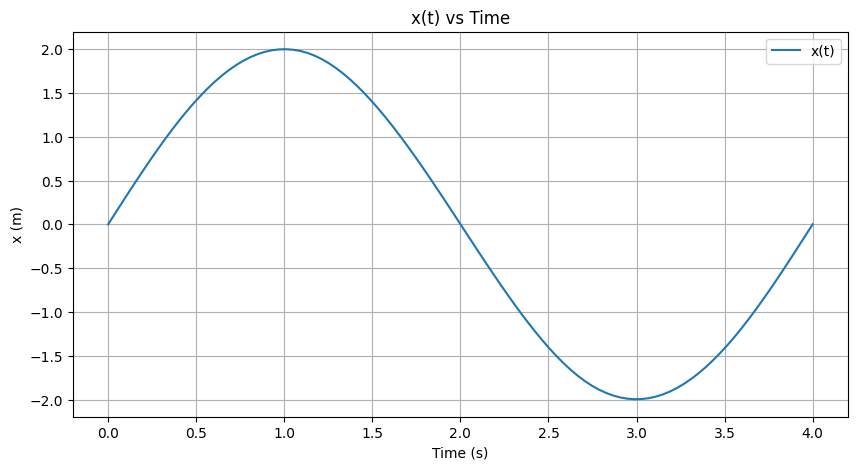

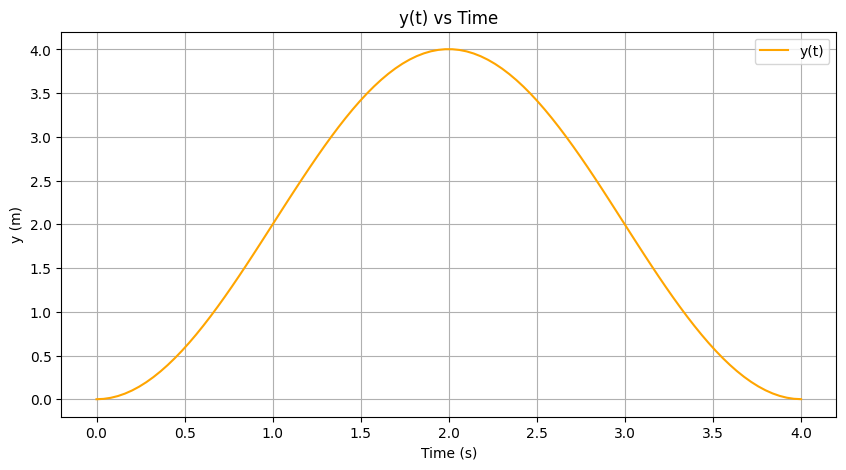

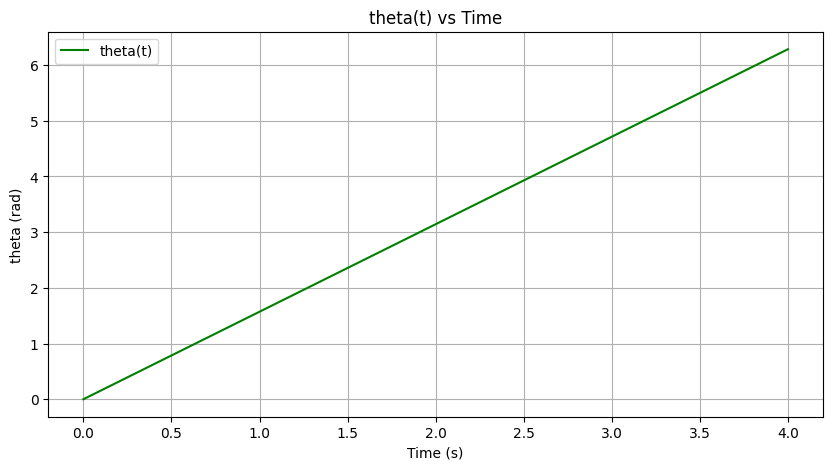

In [ ]:

r = 12.5/100  # Radius of the wheel (meters)
l = 50/100  # Distance between the wheels (meters)
initial_state = [0.0, 0.0, 0.0]  # Initial state [x0, y0, theta0]

# Function to compute omega given t and (x, y, theta)
def omega(t, xytheta):
    omega_l = (1 - l/4) * np.pi / r
    omega_r = (1 + l/4) * np.pi / r
    return np.array([omega_l, omega_r])

# Function to compute the derivative of the state
def fun(t, xytheta, omega_func):
    x, y, theta = xytheta

    # Compute omega using the given function omega
    omega_l, omega_r = omega_func(t, xytheta)

    # Calculate linear and angular velocities of the wheels
    v_l = r * omega_l
    v_r = r * omega_r

    # Calculate average linear velocity of the robot
    v = (v_r + v_l) / 2.0

    # Calculate angular velocity of the robot
    omega = (v_r - v_l) / l

    # Calculate rates of change of x, y, and theta
    x_dot = v * np.cos(theta)
    y_dot = v * np.sin(theta)
    theta_dot = omega

    return np.array([x_dot, y_dot, theta_dot])

# Define the time span
t_span = (0, 4)  # From t=0 to t=4 seconds

# Solve the differential equations numerically
solution = solve_ivp(lambda t, y: fun(t, y, omega), t_span, initial_state, method='RK45', dense_output=True)

# Compute dense outputs
t_dense = np.linspace(0, 4, 100)
states_dense = solution.sol(t_dense)

# Extract x, y, and theta from the dense solution
x_values = states_dense[0]
y_values = states_dense[1]
theta_values = states_dense[2]

# Plot x(t)
plt.figure(figsize=(10, 5))
plt.plot(t_dense, x_values, label='x(t)')
plt.title('x(t) vs Time')
plt.xlabel('Time (s)')
plt.ylabel('x (m)')
plt.grid(True)
plt.legend()
plt.show()

# Plot y(t)
plt.figure(figsize=(10, 5))
plt.plot(t_dense, y_values, label='y(t)', color='orange')
plt.title('y(t) vs Time')
plt.xlabel('Time (s)')
plt.ylabel('y (m)')
plt.grid(True)
plt.legend()
plt.show()

# Plot theta(t)
plt.figure(figsize=(10, 5))
plt.plot(t_dense, theta_values, label='theta(t)', color='green')
plt.title('theta(t) vs Time')
plt.xlabel('Time (s)')
plt.ylabel('theta (rad)')
plt.grid(True)
plt.legend()
plt.show()


pass

🧩 Use the simulation results to display the robot location every 0.5 second.

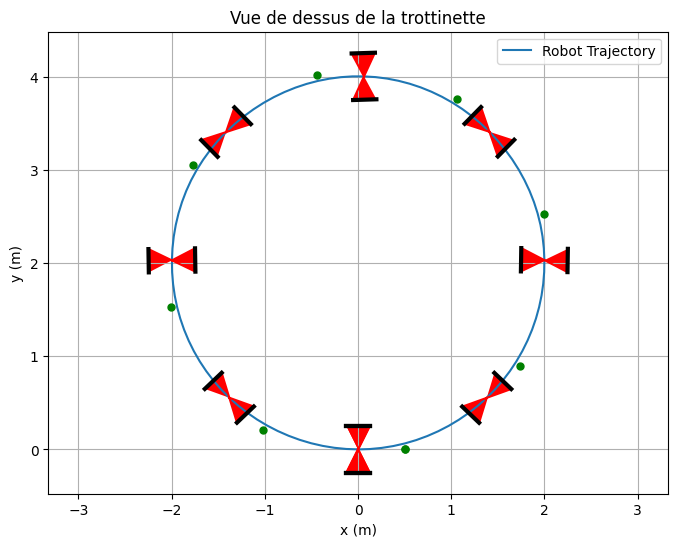

In [ ]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Function to compute omega given t and (x, y, theta)
def omega(t, xytheta):
    omega_l = (1 - l/4) * np.pi / r
    omega_r = (1 + l/4) * np.pi / r
    return np.array([omega_l, omega_r])

# Function to compute the derivative of the state
def fun(t, xytheta, omega_func):
    x, y, theta = xytheta

    # Compute omega using the given function omega
    omega_l, omega_r = omega_func(t, xytheta)

    # Calculate linear and angular velocities of the wheels
    v_l = r * omega_l
    v_r = r * omega_r

    # Calculate average linear velocity of the robot
    v = (v_r + v_l) / 2.0

    # Calculate angular velocity of the robot
    omega = (v_r - v_l) / l

    # Calculate rates of change of x, y, and theta
    x_dot = v * np.cos(theta)
    y_dot = v * np.sin(theta)
    theta_dot = omega

    return np.array([x_dot, y_dot, theta_dot])

t_span = (0, 4)  # From t=0 to t=4 seconds

# Solve the differential equations numerically
solution = solve_ivp(lambda t, y: fun(t, y, omega), t_span, initial_state, method='RK45', dense_output=True)

# Compute dense outputs
t_dense = np.linspace(0, 4, 100)
states_dense = solution.sol(t_dense)

# Extract x, y, and theta from the dense solution
x_values = states_dense[0]
y_values = states_dense[1]
theta_values = states_dense[2]

# Plot the trajectory
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Robot Trajectory')
plt.title('Robot Trajectory')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)

# Display robot location every 0.5 seconds
for t in np.arange(0, 4.5, 0.5):
    index = np.abs(t_dense - t).argmin()
    draw_scooter(x_values[index], y_values[index], theta_values[index])

plt.legend()
plt.show()
pass

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$?

\begin{align*}
x(t) &= \frac{l}{2} \frac{{(\omega_l + \omega_r)}}{{(\omega_r - \omega_l)}} \sin(\theta(t)) \\
y(t) &= \frac{l}{2} \frac{{(\omega_l + \omega_r)}}{{(\omega_r - \omega_l)}} \left(1 - \cos(\theta(t))\right) \\
\theta(t) &= \frac{r}{l} (\omega_r - \omega_l) t
\end{align*}


**TODO**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

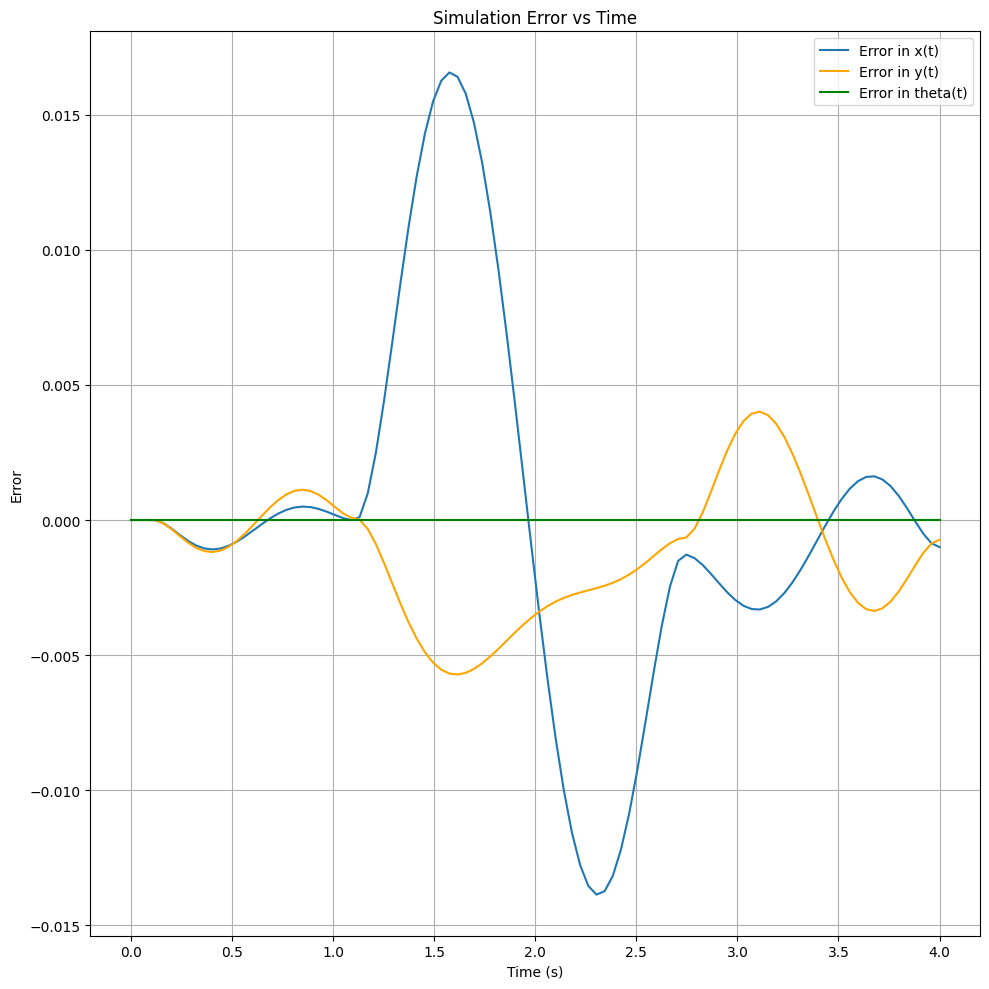

In [ ]:
wl, wr = omega(0, [0, 0, 0])

def x(t):
    return l / 2 * (wl + wr) / (wr - wl) * np.sin(theta(t))

def y(t):
    return l / 2 * (wl + wr) / (wr - wl) * (1 - np.cos(theta(t)))

def theta(t):
    return r / l * (wr - wl) * t

# Calculate the theoretical values
t_values = np.linspace(0, 4, 100)
x_theoretical = [x(t) for t in t_values]
y_theoretical = [y(t) for t in t_values]
theta_theoretical = [theta(t) for t in t_values]

x_values_simulated = states_dense[0]
y_values_simulated = states_dense[1]
theta_values_simulated = states_dense[2]
x_error = [x_theoretical[i] - x_values_simulated[i] for i in range(len(t_values))]
y_error = [y_theoretical[i] - y_values_simulated[i] for i in range(len(t_values))]
theta_error = [theta_theoretical[i] - theta_values_simulated[i] for i in range(len(t_values))]

# Plot the error curves
plt.figure(figsize=(10, 10))

plt.plot(t_values, x_error, label='Error in x(t)')
plt.plot(t_values, y_error, label='Error in y(t)', color='orange')
plt.plot(t_values, theta_error, label='Error in theta(t)', color='green')

plt.title('Simulation Error vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$.

not needed